22050

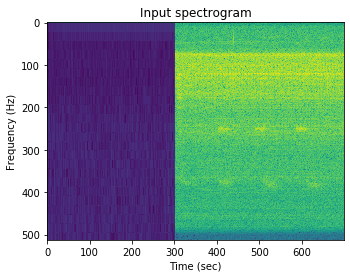

In [52]:
from numpy import *
import scipy
from scipy.sparse.linalg import eigsh
import librosa
import IPython.display as ipd
path = "/Users/sogolbz/Documents/Signal hw/Project/data/"
filename = "zuzanaCombined.wav"
from matplotlib.pylab import *
import scipy.io.wavfile
from scipy import signal



fs,s = scipy.io.wavfile.read(path + filename)

s = s.astype( float64)

# Get the magnitude spectrogram
q,t,f = signal.stft( s, fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
h = f
f = abs( f)
subplot( 1, 1, 1), pcolormesh( t, q, f**0.4), title( 'Input spectrogram')
xlabel( 'Time (sec)'), ylabel( 'Frequency (Hz)')
plt.imshow(log(f[:, 300:1000]))

fs


22050

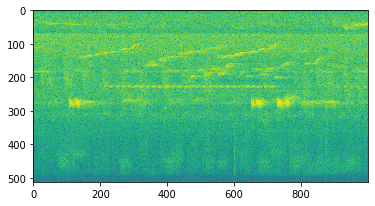

In [53]:
fs,s = scipy.io.wavfile.read(path + "GGAD_3mins.wav")

s = s.astype(float64)

q,t,cur_Zxx = signal.stft( s, fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
cur_Zxx = abs(cur_Zxx)

plt.imshow(log(cur_Zxx[:, :1000]))
fs

In [54]:
cur_Zxx.shape

(513, 15961)

In [56]:
f = np.hstack((f, cur_Zxx))

In [57]:
f.shape

(513, 41911)

In [58]:


def create_chunks(samples, framesPerChunk = 20):
    newMat = np.zeros((samples.shape[0] * framesPerChunk,1))
    chunked = []
    for colNum in range(0, np.shape(samples)[1], framesPerChunk):
        if (colNum + framesPerChunk > samples.shape[1]):
            break
        matrix = samples[:, colNum:colNum + framesPerChunk]
        matrix = matrix.flatten('F')
        matrix = np.reshape(matrix, (matrix.shape[0], 1))
        newMat = np.hstack((newMat, matrix))
    return newMat[:,1:]

def pca( x, k):
    # Remove data mean
    xm = x - mean( x, axis=1, keepdims=True)

    # Get covariance estimate
    C = xm.dot( xm.T) / (xm.shape[1]-1)

    # Get top k PCA covariance eigenvectors/values
    v,u = eigsh( C, k=k)

    # Get overall transform and the input's projection to k dimensions
    w = diag( 1./sqrt(v)) @ u.T
    y = w @ xm
    
    return w,y



In [59]:
f.shape

(513, 41911)

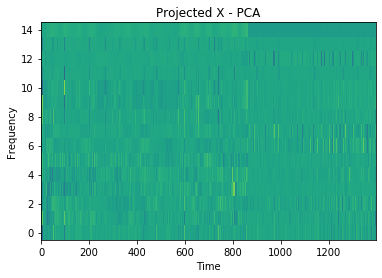

In [60]:



from sklearn.decomposition import PCA
chunk = create_chunks(f, 30)
W,Z = pca(chunk, 15)


import matplotlib.pyplot as plot

fig_xhat = plot.figure()  
plot.title('Projected X - PCA')
plot.xlabel('Time')
plot.ylabel('Frequency')
plot.imshow(Z, interpolation="none", origin='lower', aspect='auto')




In [216]:

def euclidean_dist(x1, x2):
    return np.sum((x1 - x2)**2)**0.5

def check_equality(x1, x2):
    if len(x1) != len(x2):
        return False
    for i in range(len(x1)):
        if np.array_equal(x1[i], x2[i]) == False:
            return False
    return True

def kmeans(initialization, Z, red_dims = 8):
    means = initialization
    k_clusters = len(initialization)
    print("**inistial" +str( k_clusters))
    iteration = 0
    prev = []
    for i in range(k_clusters):
        prev.append(np.zeros((red_dims,1)))
    print("prev", str(len(prev)))
        
    while check_equality(means, prev) == False:
        prev = means
        collect =[]
        for i in range(k_clusters):
            collect.append(np.zeros((red_dims,1)))
            
        labels = []
        for i in range(Z.shape[1]):
            e_dist = [euclidean_dist(Z[:,i].flatten('F').reshape((red_dims,1)), means[j]) for j in range(k_clusters)]
#             print(k_clusters)
            
            k = sorted(range(k_clusters), key = lambda k: e_dist[k])[0]
#             print("clusters" + str(k))
            labels += [k]
            collect[k] += Z[:, i].flatten('F').reshape((red_dims,1))
        count = [0,0,0]
        for i in labels:
            count[i] += 1
        means = [collect[k]/count[k] for k in range(k_clusters)]
        iteration += 1
    return means, labels

# GMM

def normal_dist(x, mu, covar):
    n = x.shape[0]
    red_mean = x - mu
    covar_det = np.linalg.det(covar)
    covar_inv = np.linalg.pinv(covar)
    pdf = ((1/(((2*np.pi)**(n/2)) * covar_det**0.5)) * np.exp(-0.5 * ((red_mean.T @ covar_inv) @ red_mean )))
    return pdf[0][0]

def likelihood(Z, pi, cov, mean, red_dims = 20):
    value = 0
    for i in range(Z.shape[1]):
        x = Z[:, i].flatten('F').reshape((red_dims, 1))
        val = 0
        k_clusters = len(mean)
        print("mean len" + str(k_clusters))
        for j in range(k_clusters):
            val += pi[j] * normal_dist(x, mean[j], cov[j])
        value += np.log(val)
    return value

def gmm_em(initialization, Z, red_dims = 8):
    pi = initialization['pi']
    cov = initialization['cov']
    mean = initialization['mean']
    prev, iteration = 0, 0
    loglike = likelihood(Z, pi, cov, mean, red_dims)
    
    k_clusters = len(initialization)
    while np.abs(prev - loglike) < 1e-6:
        prev = loglike
        
        # Expectation step
        gamma = []
        for i in range(Z.shape[1]):
            x = Z[:, i].flatten('F').reshape((red_dims, 1))
            temp = []
            temp_sum = 0
            for j in range(k_clusters):
                print(len(mean))
                t1 = pi[j] * normal_dist(x, mean[j], cov[j])
                temp += [t1]
                temp_sum += t1
            gamma += [[k/temp_sum for k in temp]]
        
        # Maximization step
        mean_temp = []
        for z in range(k_clusters):
            mean_temp.append(np.zeros((red_dims, 1)))
        pi_temp = []
        for z in range(k_clusters):
            mean_temp.append(0)
            
            
        for i in range(Z.shape[1]):
            x = Z[:, i].flatten('F').reshape((red_dims, 1))
            for j in range(k_clusters):
                pi_temp[j] += gamma[i][j]
                mean_temp[j] += gamma[i][j] * x
        
        pi = [pi_temp[k]/Z.shape[1] for k in range(k_clusters)]
        mean = [mean_temp[k]/pi_temp[k] for k in range(k_clusters)]
        
        cov_temp = []
        for z in range(k_clusters):
            cov_temp.append(np.zeros((red_dims, red_dims)))
#         cov_temp = [np.zeros((red_dims, red_dims)), np.zeros((red_dims, red_dims))]
        for i in range(Z.shape[1]):
            x = Z[:, i].flatten('F').reshape((red_dims, 1))
            for j in range(k_clusters):
                cov_temp[j] += gamma[i][j] * ((x - mean[j]) @ (x - mean[j]).T)
        cov = [cov_temp[k]/pi_temp[k] for k in range(k_clusters)]
        iteration += 1
        loglike = likelihood(Z, pi, cov, mean, red_dims)
   
    labels = []
    for i in range(Z.shape[1]):
        x = Z[:, i].flatten('F').reshape((red_dims, 1))
        sortStuff = [normal_dist(x, mean[k], cov[k]) for k in range(2)]
        labels += [sorted(range(2), key = lambda k: sortStuff[k], reverse = True)[0]]
    return labels





In [217]:
Z.shape
len(means)

2

In [218]:
red_dims = 15
# K-Means initialization
means = [np.zeros((red_dims,1)), np.zeros((red_dims,1))]
means[0] = np.average(Z[:, 0:65], axis = 1).flatten('F').reshape((red_dims,1)) #speech
means[1] = np.average(Z[:,330:345 ], axis = 1).flatten('F').reshape((red_dims,1)) #music
# means[2] = np.average(Z[:, 240:289], axis = 1).flatten('F').reshape((red_dims,1)) #laughter
len(means)



means_kmeans, labels_kmeans = kmeans(means, Z, red_dims)

**inistial2
prev 2


In [219]:
labels_kmeans

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [220]:


red_dims = 15
# K-Means initialization
means = [np.zeros((red_dims,1)), np.zeros((red_dims,1))]
means[0] = np.average(Z[:, 0:65], axis = 1).flatten('F').reshape((red_dims,1)) #speech
means[1] = np.average(Z[:,330:345 ], axis = 1).flatten('F').reshape((red_dims,1)) #music
# means[2] = np.average(Z[:, 240:289], axis = 1).flatten('F').reshape((red_dims,1)) #laughter
len(means)



means_kmeans, labels_kmeans = kmeans(means, Z, red_dims)
# check_accuracy(labels_kmeans)

#---------------------------------

# GMM clustering initialization
count = [0, 0, 0]
for i in labels_kmeans:
    count[i] += 1
cov_l = [np.zeros((red_dims, red_dims)), np.zeros((red_dims, red_dims))]
for i, l in enumerate(labels_kmeans):
    x1 = Z[:, i].flatten('F').reshape((red_dims, 1))
    cov_l[l] += ((x1 - means_kmeans[l]) @ (x1 - means_kmeans[l]).T)
cov = [cov_l[k]/(count[k] - 1) for k in range(2)]
initial = {'pi' : [i/len(labels_kmeans) for i in count], 'cov' : cov, 'mean' : means_kmeans}

labels_gmm = gmm_em(initial, Z, red_dims = red_dims)
# # check_accuracy(labels_gmm)



**inistial2
prev 2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
m

mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2
mean len2


In [ ]:
labels_gmm

In [ ]:
first =0 
second =0
import pandas as pd
data = []
firstCluster_frames = np.zeros((513, 1))
secondCluster_frames = np.zeros((513, 1))

for i in range(len(labels_kmeans)):
    print(labels_kmeans[i], i*30/1000)
    if labels_kmeans[i] == 0:
        first +=1
        firstCluster_frames = np.hstack((firstCluster_frames, f[:, i*30:i*30 + 29]))
        
    else:
        second+=1
        secondCluster_frames = np.hstack((secondCluster_frames, f[:, i*30:i*30 + 29]))





552

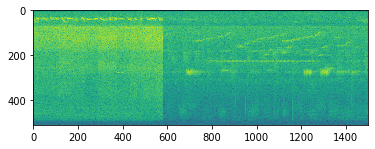

In [179]:



Z.shape

if first > second:
    _, xrec = signal.istft( firstCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
    scipy.io.wavfile.write("AllNoise_kmeans.wav",fs,xrec)
    _, xrec = signal.istft( secondCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
    scipy.io.wavfile.write("AllBird_kmeans.wav",fs,xrec)
else:
    _, xrec = signal.istft( secondCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
    scipy.io.wavfile.write("AllNoise_kmeans.wav",fs,xrec)
    _, xrec = signal.istft( firstCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
    scipy.io.wavfile.write("AllBird_kmeans.wav",fs,xrec)



plt.imshow(log(firstCluster_frames[:,1:1500]))
first



845

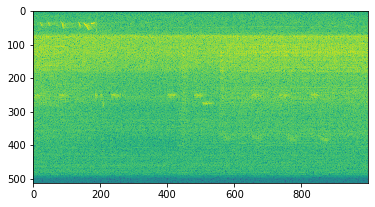

In [180]:
plt.imshow(log(secondCluster_frames[:,1:1000]))
second

In [181]:
first =0 
second =0
import pandas as pd
data = []
firstCluster_frames = np.zeros((513, 1))
secondCluster_frames = np.zeros((513, 1))

for i in range(len(labels_gmm)):
    print(labels_gmm[i], i*30/1000)
    if labels_gmm[i] == 0:
        first +=1
        firstCluster_frames = np.hstack((firstCluster_frames, f[:, i*30:i*30 + 29]))
        
    else:
        second+=1
        secondCluster_frames = np.hstack((secondCluster_frames, f[:, i*30:i*30 + 29]))






if first > second:
    _, xrec = signal.istft( firstCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
    scipy.io.wavfile.write("AllNoise_gmm.wav",fs,xrec)
    _, xrec = signal.istft( secondCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
    scipy.io.wavfile.write("AllBird_gmm.wav",fs,xrec)
else:
    _, xrec = signal.istft( secondCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
    scipy.io.wavfile.write("AllNoise_gmm.wav",fs,xrec)
    _, xrec = signal.istft( firstCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)
    scipy.io.wavfile.write("AllBird_gmm.wav",fs,xrec)

# _, xrec = signal.istft( secondCluster_frames[:,1:], fs=fs, window=signal.get_window('hann', 1024), nperseg=1024, noverlap=768)



1 0.0
1 0.03
1 0.06
1 0.09
1 0.12
1 0.15
0 0.18
1 0.21
1 0.24
1 0.27
1 0.3
1 0.33
1 0.36
1 0.39
1 0.42
1 0.45
1 0.48
1 0.51
0 0.54
1 0.57
1 0.6
1 0.63
1 0.66
1 0.69
1 0.72
1 0.75
1 0.78
1 0.81
1 0.84
1 0.87
1 0.9
1 0.93
1 0.96
1 0.99
1 1.02
1 1.05
1 1.08
1 1.11
1 1.14
1 1.17
1 1.2
1 1.23
1 1.26
1 1.29
1 1.32
1 1.35
1 1.38
1 1.41
1 1.44
1 1.47
1 1.5
1 1.53
1 1.56
1 1.59
1 1.62
1 1.65
1 1.68
1 1.71
1 1.74
1 1.77
1 1.8
1 1.83
1 1.86
1 1.89
1 1.92
1 1.95
1 1.98
1 2.01
1 2.04
1 2.07
1 2.1
1 2.13
1 2.16
1 2.19
1 2.22
1 2.25
1 2.28
1 2.31
1 2.34
1 2.37
1 2.4
1 2.43
1 2.46
1 2.49
1 2.52
1 2.55
1 2.58
1 2.61
1 2.64
1 2.67
1 2.7
1 2.73
1 2.76
1 2.79
1 2.82
1 2.85
1 2.88
1 2.91
1 2.94
1 2.97
1 3.0
1 3.03
1 3.06
1 3.09
1 3.12
1 3.15
1 3.18
1 3.21
1 3.24
1 3.27
1 3.3
1 3.33
1 3.36
1 3.39
1 3.42
1 3.45
1 3.48
1 3.51
1 3.54
1 3.57
1 3.6
1 3.63
1 3.66
1 3.69
1 3.72
1 3.75
1 3.78
1 3.81
1 3.84
1 3.87
1 3.9
1 3.93
1 3.96
1 3.99
1 4.02
1 4.05
1 4.08
1 4.11
1 4.14
1 4.17
1 4.2
1 4.23
1 4.26
1 4.29
1 4.32


0 32.73
0 32.76
0 32.79
0 32.82
0 32.85
0 32.88
0 32.91
0 32.94
0 32.97
0 33.0
0 33.03
0 33.06
0 33.09
0 33.12
0 33.15
0 33.18
0 33.21
0 33.24
0 33.27
0 33.3
0 33.33
0 33.36
0 33.39
0 33.42
0 33.45
0 33.48
0 33.51
0 33.54
0 33.57
0 33.6
0 33.63
0 33.66
0 33.69
0 33.72
0 33.75
0 33.78
0 33.81
0 33.84
0 33.87
0 33.9
0 33.93
0 33.96
0 33.99
0 34.02
0 34.05
0 34.08
0 34.11
0 34.14
0 34.17
0 34.2
0 34.23
0 34.26
0 34.29
0 34.32
0 34.35
0 34.38
0 34.41
0 34.44
0 34.47
0 34.5
0 34.53
0 34.56
0 34.59
0 34.62
0 34.65
0 34.68
0 34.71
0 34.74
0 34.77
0 34.8
0 34.83
0 34.86
0 34.89
0 34.92
0 34.95
0 34.98
0 35.01
0 35.04
0 35.07
0 35.1
0 35.13
0 35.16
0 35.19
0 35.22
0 35.25
0 35.28
0 35.31
0 35.34
0 35.37
0 35.4
0 35.43
0 35.46
0 35.49
0 35.52
0 35.55
0 35.58
0 35.61
0 35.64
0 35.67
0 35.7
0 35.73
0 35.76
0 35.79
0 35.82
0 35.85
0 35.88
0 35.91
0 35.94
0 35.97
0 36.0
0 36.03
0 36.06
0 36.09
0 36.12
0 36.15
0 36.18
0 36.21
0 36.24
0 36.27
0 36.3
0 36.33
0 36.36
0 36.39
0 36.42
0 36.45
0 36.48
0 36

848

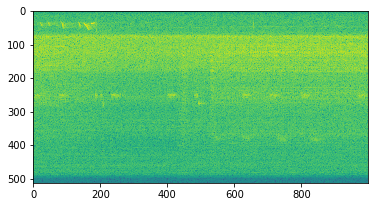

In [182]:
plt.imshow(log(secondCluster_frames[:,1:1000]))
second



549

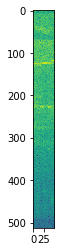

In [183]:
plt.imshow(log(firstCluster_frames[:,700:750]))
first



## 3 clusters for lower frequency birds

In [190]:
red_dims = 15
# K-Means initialization
means = [np.zeros((red_dims,1)), np.zeros((red_dims,1)), np.zeros((red_dims,1))]
means[0] = np.average(Z[:, 0:65], axis = 1).flatten('F').reshape((red_dims,1)) #speech
means[1] = np.average(Z[:,330:345 ], axis = 1).flatten('F').reshape((red_dims,1)) #music

low_freq_birds = np.hstack((Z[:, 27:60], Z[:,600:650], Z[:,700:750]))
means[2] = np.average(low_freq_birds, axis = 1).flatten('F').reshape((red_dims,1)) #laughter
len(means)



means_kmeans, labels_kmeans = kmeans(means, Z, red_dims)

**inistial3
prev 3


(15, 133)